In [4]:
import numpy as np
import math
import os, time, sys
import pickle
from matplotlib import pyplot as plt

#### Local Files
import vector_CD.data_generation.gen_data_vecCI_ext as mod1
import vector_CD.data_generation.mult_data_gen_methods as mech
import vector_CD.CD_methods.vec_CD_methods as cd
import vector_CD.CD_methods.metrics_vec_CD as met
######

import tigramite
import tigramite.data_processing as pp
from tigramite import plotting as tp
from tigramite.pcmci import PCMCI
from tigramite.independence_tests.parcorr import ParCorr

def lin_f(x): return x

In [5]:
os.getcwd()

'/Users/urmininad/Documents/Python/vector_CD/vector_CD/Jupyter_notebooks'

## Function defs

In [521]:
print_graph = False
def calculate(para_setup):
    
    para_setup_string, sam = para_setup
    paras = para_setup_string.split('-')
    paras = [w.replace("'","") for w in paras]
    
    data_gen = str(paras[0])
    d_macro = int(paras[1])
    d_micro = int(paras[2])
    T = int(paras[3])
    coeff = float(paras[4])
    auto = float(paras[5])
    contemp_frac = float(paras[6])
    pc_alpha = float(paras[7])
    tau_max = int(paras[8])
    method = str(paras[9])
    corr_type = str(paras[10])
    reg_type = str(paras[11])
    
    if len(paras)>12:
        internal_ER = float(paras[12]) #ER: erdos-renyi probability
        external_ER = float(paras[13])
        neg = float(paras[14])
        # pca_weight = float(paras[15])
        # cov_weight = float(paras[15])
        pca_weight = None
    else:
        internal_ER = None
        external_ER = None
        neg = 'symm'
        pca_weight = None
    
    # print(data_gen, d_macro, d_micro, T, coeff, auto, contemp_frac, pc_alpha, tau_max, method, corr_type, reg_type)
    print("METHOD", method)
    
    #############################################
    ##  Data Generation 
    #############################################    
    
    if 'coarse_dag' in data_gen:
        data, true_graph = mech.data_coarse_dag(data_gen,sam,d_macro,d_micro,coeff,auto,
                                          tau_max,contemp_frac,T,
                                          neg,
                                          internal_ER = internal_ER,
                                          external_ER = external_ER)
    elif 'cbm' in data_gen:
        data, true_graph = mech.data_mrf(d_macro,d_micro, sam, T)  
        
    elif 'mrf_ts' in data_gen:
        data, true_graph = mech.data_mrf_ts(data_gen,sam,d_macro,d_micro,coeff,auto,
                                          neg,
                                          pca_weight,
                                          tau_max,contemp_frac,T,
                                          internal_er = internal_ER,
                                          external_er = external_ER)   
        # data, true_graph = mech.data_mrf_ts_weighted_cov(data_gen,sam,d_macro,d_micro,coeff,auto,
        #                                   neg,
        #                                   cov_weight,
        #                                   pca_weight,
        #                                   tau_max,contemp_frac,T,
        #                                   internal_er = internal_ER,
        #                                   external_er = external_ER)    
    elif 'savar' in data_gen:
        data, true_graph = mech.data_savar(d_macro,d_micro, sam, T, coeff, auto, contemp_frac, tau_max)
        
    # Evaluate against CPDAG not DAG!
    true_graph = mech.dag_to_cpdag(true_graph, tau_max)
        
    #############################################
    ##  Cond ind test
    #############################################
    if 'vec' in method:
        # print("vector PCMCI running......")
        cond_ind_test = cd.get_cmi(reg_type, corr_type)
        
    elif 'avg' in method or 'vanilla' in method:
        # print("avg or vanilla PCMCI running......")
        cond_ind_test = ParCorr(
        significance='analytic', 
        recycle_residuals=True)
        
    elif 'pca_pcmci' in method:
        # print("Principal component PCMCI running......")
        if method == 'pca_pcmci':
            p_comps = 1
            cond_ind_test = ParCorr(
            significance='analytic', 
            recycle_residuals=True)
        else:
            p_comps  = int(method.replace('pca_pcmci_',''))
            if p_comps==1:
                cond_ind_test = ParCorr(
                significance='analytic', 
                recycle_residuals=True)
            elif p_comps > d_micro:
                raise ValueError("principal components can't be larger than d_micro")
            else:
                cond_ind_test = cd.get_cmi(reg_type, corr_type)
    
    #############################################
    ##  Vec-CD Methods
    #############################################
    computation_time_start = time.time()

    if 'vec_pcmci' in method:
        graph = cd.vec_pcmci(data, d_macro, d_micro, cond_ind_test, tau_max, pc_alpha)
    elif 'avg_pcmci' in method:
        graph = cd.avg_pcmci(data, d_macro, d_micro, cond_ind_test, tau_max, pc_alpha)
    elif 'pca_pcmci' in method:
        graph = cd.pca_pcmci(data, d_macro, d_micro, p_comps, cond_ind_test, tau_max, pc_alpha)
    elif 'vanilla_pcmci' in method:
        graph = cd.vanilla_pcmci(data, d_macro, d_micro, cond_ind_test, tau_max, pc_alpha)
        
    computation_time_end = time.time()
    computation_time = computation_time_end - computation_time_start
    
    if print_graph == True:
        
        tp.plot_graph(
        graph=true_graph,
        link_colorbar_label='cross-MCI',
        node_colorbar_label='auto-MCI',
        show_autodependency_lags=False
        ); plt.show()

        # print('Graph',graph)
        tp.plot_graph(
        graph=graph,
        link_colorbar_label='cross-MCI',
        node_colorbar_label='auto-MCI',
        show_autodependency_lags=False
        ); plt.show()
        
    return {
            'true_graph':true_graph,
            'graph':graph,
            'computation_time': computation_time,
            }  

In [522]:
# TODO: Implement an already_there 
##########

def compute_reps(config_list, samples):
    all_configs = dict([(conf, {
        'results':{}, 
        "graphs":{}, 
        "true_graph":{}, 
        "computation_time":{},} ) for conf in config_list])
    job_list = [(conf, i) for i in range(samples) for conf in config_list]
    config_chunks = [job_list]

    def process_chunks(job_id, chunk):
        results = {}
        num_here = len(chunk)
        time_start_process = time.time()
        for isam, config_sam in enumerate(chunk):
            print(config_sam,'\n------------\n')
            results[config_sam] = calculate(config_sam)
        return results

    for job_id, chunk in enumerate(config_chunks):
        tmp = process_chunks(job_id, chunk)
        for conf_sam in list(tmp.keys()):
            config = conf_sam[0]
            sample = conf_sam[1]
            all_configs[config]['results'][sample] = tmp[conf_sam]
        
    return all_configs

In [523]:
def save_results(all_configs):
    
    for conf in list(all_configs.keys()):

        all_configs[conf]['graphs'] = np.zeros((samples, ) + all_configs[conf]['results'][0]['graph'].shape, dtype='<U3')
        all_configs[conf]['true_graphs'] = np.zeros((samples, ) + all_configs[conf]['results'][0]['true_graph'].shape, dtype='<U3')
        all_configs[conf]['computation_time'] = [] 


        for i in list(all_configs[conf]['results'].keys()):
            all_configs[conf]['graphs'][i] = all_configs[conf]['results'][i]['graph']
            all_configs[conf]['true_graphs'][i] = all_configs[conf]['results'][i]['true_graph']
            all_configs[conf]['computation_time'].append(all_configs[conf]['results'][i]['computation_time'])


        del all_configs[conf]['results']

        if os.path.expanduser('~') == '/Users/urmininad':
            file_name = os.path.expanduser('~') + '/Documents/Python/Mult_CI_Tests/Interimresults_vecCI/%s' %(conf)
            file_name_met = os.path.expanduser('~') + '/Documents/Python/Mult_CI_Tests/metrics_vecCI/%s' %(conf)
        else:
            print("wrong path for running locally")

        print("dump ", file_name.replace("'", "").replace('"', '') + '.dat')
        file = open(file_name.replace("'", "").replace('"', '') + '.dat', 'wb')
        pickle.dump(all_configs[conf], file, protocol=-1)        
        file.close()

        # Directly compute metrics and save in much smaller dict
        para_setup_str = tuple(conf.split("-"))
        metrics = met.get_counts(para_setup_str)

        if metrics is not None:
            for metric in metrics:
                if metric != 'computation_time':
                    print(f"{metric:30s} {metrics[metric][0]: 1.2f} +/-{metrics[metric][1]: 1.2f} ")
                else:
                    print(f"{metric:30s} {metrics[metric][0]: 1.2f} +/-[{metrics[metric][1][0]: 1.2f}, {metrics[metric][1][1]: 1.2f}]")

            print("Metrics dump ", file_name_met.replace("'", "").replace('"', '') + '_metrics.dat')
            file = open(file_name_met.replace("'", "").replace('"', '') + '_metrics.dat', 'wb')
            pickle.dump(metrics, file, protocol=-1)        
            file.close()

        else:
            print("Metrics is None, CHECK!!!!!")

## Run Experiments

In [528]:
ER = True # ER indicates that the internal and extetnal densities are given in terms of ER probabilities
if ER: 
    anyconfigurations = [] 
    for data_gen in ['mrf_ts']:#['mrf_ts_weighted_cov']:#, 'mrf_ts_online_pca_bias 'coarse_dag','mrf_ts','mrf','savar']:    
        for d_macro in [5]:
            for d_micro in [3]:   
                for coeff in [0.5]:
                    for auto in [0.3]:
                        for contemp_frac in [0.3]:#[1.]:
                            for T in [200]:
                                method_list = ['vec_pcmci', 'pca_pcmci']
                                #['vec_pcmci','avg_pcmci','pca_pcmci','pca_pcmci_2','vanilla_pcmci']
                                for method in method_list: 
                                    for corr_type in ['gcm_gmb']:# ['maxcorr, gcm, linear_hsic']:
                                        for reg_type in ['ols']: #['ridge','pls']:
                                            for pc_alpha in [0.01]:
                                                for tau_max in [1]:#[0]:
                                                    for internal_ER in [0.3]:#[0.1,0.3,0.5,0.7,1.0]: #[0.3]:
                                                        for external_ER in [0.1,0.2,0.3,0.4,0.5]:#[0.5]:[0.1,0.3,0.5,0.7,1.0]:#[1.0, 0.7, 0.5, 0.3, 0.1]: 
                                                            for neg in [1.]:#[0.,0.2,0.4,0.6,0.8,1.]: 
                                                                # for pca_weight in ['None']:#[0.,0.1,0.2,0.3,0.4]: #cov_weight in [2,5,10,20]:
                                                                    para_setup = (data_gen, d_macro, d_micro, T, coeff, auto, contemp_frac, pc_alpha, tau_max, 
                                                                                  method, corr_type, reg_type, internal_ER, external_ER, neg)#, pca_weight)
                                                                    name = '%s-'*len(para_setup) % para_setup
                                                                    name = name[:-1]
                                                                    anyconfigurations += [name]

    config_list = anyconfigurations 
config_list

['mrf_ts-5-3-200-0.5-0.3-0.3-0.01-1-vec_pcmci-gcm_gmb-ols-0.3-0.1-1.0',
 'mrf_ts-5-3-200-0.5-0.3-0.3-0.01-1-vec_pcmci-gcm_gmb-ols-0.3-0.2-1.0',
 'mrf_ts-5-3-200-0.5-0.3-0.3-0.01-1-vec_pcmci-gcm_gmb-ols-0.3-0.3-1.0',
 'mrf_ts-5-3-200-0.5-0.3-0.3-0.01-1-vec_pcmci-gcm_gmb-ols-0.3-0.4-1.0',
 'mrf_ts-5-3-200-0.5-0.3-0.3-0.01-1-vec_pcmci-gcm_gmb-ols-0.3-0.5-1.0',
 'mrf_ts-5-3-200-0.5-0.3-0.3-0.01-1-pca_pcmci-gcm_gmb-ols-0.3-0.1-1.0',
 'mrf_ts-5-3-200-0.5-0.3-0.3-0.01-1-pca_pcmci-gcm_gmb-ols-0.3-0.2-1.0',
 'mrf_ts-5-3-200-0.5-0.3-0.3-0.01-1-pca_pcmci-gcm_gmb-ols-0.3-0.3-1.0',
 'mrf_ts-5-3-200-0.5-0.3-0.3-0.01-1-pca_pcmci-gcm_gmb-ols-0.3-0.4-1.0',
 'mrf_ts-5-3-200-0.5-0.3-0.3-0.01-1-pca_pcmci-gcm_gmb-ols-0.3-0.5-1.0']

In [529]:
samples = 100 #not sample size, but number of repetitions
all_configs = compute_reps(config_list, samples)

('mrf_ts-5-3-200-0.5-0.3-0.3-0.01-1-vec_pcmci-gcm_gmb-ols-0.3-0.1-1.0', 0) 
------------

METHOD vec_pcmci
('mrf_ts-5-3-200-0.5-0.3-0.3-0.01-1-vec_pcmci-gcm_gmb-ols-0.3-0.2-1.0', 0) 
------------

METHOD vec_pcmci
('mrf_ts-5-3-200-0.5-0.3-0.3-0.01-1-vec_pcmci-gcm_gmb-ols-0.3-0.3-1.0', 0) 
------------

METHOD vec_pcmci
('mrf_ts-5-3-200-0.5-0.3-0.3-0.01-1-vec_pcmci-gcm_gmb-ols-0.3-0.4-1.0', 0) 
------------

METHOD vec_pcmci
('mrf_ts-5-3-200-0.5-0.3-0.3-0.01-1-vec_pcmci-gcm_gmb-ols-0.3-0.5-1.0', 0) 
------------

METHOD vec_pcmci
('mrf_ts-5-3-200-0.5-0.3-0.3-0.01-1-pca_pcmci-gcm_gmb-ols-0.3-0.1-1.0', 0) 
------------

METHOD pca_pcmci
('mrf_ts-5-3-200-0.5-0.3-0.3-0.01-1-pca_pcmci-gcm_gmb-ols-0.3-0.2-1.0', 0) 
------------

METHOD pca_pcmci
('mrf_ts-5-3-200-0.5-0.3-0.3-0.01-1-pca_pcmci-gcm_gmb-ols-0.3-0.3-1.0', 0) 
------------

METHOD pca_pcmci
('mrf_ts-5-3-200-0.5-0.3-0.3-0.01-1-pca_pcmci-gcm_gmb-ols-0.3-0.4-1.0', 0) 
------------

METHOD pca_pcmci
Trial 0: Not a stationary model
('mrf

/Users/urmininad/Documents/Python/Mult_CI_Tests/mult_data_gen_methods.py:654: RuntimeWarning: overflow encountered in add
  data[t, j*d_micro:(j+1)*d_micro] +=  func(data[t + lag, var*d_micro:(var+1)*d_micro]) @ coeff_mats[j,var]
/Users/urmininad/Documents/Python/Mult_CI_Tests/mult_data_gen_methods.py:654: RuntimeWarning: invalid value encountered in matmul
  data[t, j*d_micro:(j+1)*d_micro] +=  func(data[t + lag, var*d_micro:(var+1)*d_micro]) @ coeff_mats[j,var]


('mrf_ts-5-3-200-0.5-0.3-0.3-0.01-1-pca_pcmci-gcm_gmb-ols-0.3-0.1-1.0', 9) 
------------

METHOD pca_pcmci
('mrf_ts-5-3-200-0.5-0.3-0.3-0.01-1-pca_pcmci-gcm_gmb-ols-0.3-0.2-1.0', 9) 
------------

METHOD pca_pcmci
('mrf_ts-5-3-200-0.5-0.3-0.3-0.01-1-pca_pcmci-gcm_gmb-ols-0.3-0.3-1.0', 9) 
------------

METHOD pca_pcmci
('mrf_ts-5-3-200-0.5-0.3-0.3-0.01-1-pca_pcmci-gcm_gmb-ols-0.3-0.4-1.0', 9) 
------------

METHOD pca_pcmci
('mrf_ts-5-3-200-0.5-0.3-0.3-0.01-1-pca_pcmci-gcm_gmb-ols-0.3-0.5-1.0', 9) 
------------

METHOD pca_pcmci
Trial 0: Not a stationary model
Trial 1: Not a stationary model


/Users/urmininad/Documents/Python/Mult_CI_Tests/mult_data_gen_methods.py:654: RuntimeWarning: overflow encountered in add
  data[t, j*d_micro:(j+1)*d_micro] +=  func(data[t + lag, var*d_micro:(var+1)*d_micro]) @ coeff_mats[j,var]
/Users/urmininad/Documents/Python/Mult_CI_Tests/mult_data_gen_methods.py:654: RuntimeWarning: invalid value encountered in matmul
  data[t, j*d_micro:(j+1)*d_micro] +=  func(data[t + lag, var*d_micro:(var+1)*d_micro]) @ coeff_mats[j,var]


('mrf_ts-5-3-200-0.5-0.3-0.3-0.01-1-vec_pcmci-gcm_gmb-ols-0.3-0.1-1.0', 10) 
------------

METHOD vec_pcmci
('mrf_ts-5-3-200-0.5-0.3-0.3-0.01-1-vec_pcmci-gcm_gmb-ols-0.3-0.2-1.0', 10) 
------------

METHOD vec_pcmci
('mrf_ts-5-3-200-0.5-0.3-0.3-0.01-1-vec_pcmci-gcm_gmb-ols-0.3-0.3-1.0', 10) 
------------

METHOD vec_pcmci
('mrf_ts-5-3-200-0.5-0.3-0.3-0.01-1-vec_pcmci-gcm_gmb-ols-0.3-0.4-1.0', 10) 
------------

METHOD vec_pcmci
('mrf_ts-5-3-200-0.5-0.3-0.3-0.01-1-vec_pcmci-gcm_gmb-ols-0.3-0.5-1.0', 10) 
------------

METHOD vec_pcmci
('mrf_ts-5-3-200-0.5-0.3-0.3-0.01-1-pca_pcmci-gcm_gmb-ols-0.3-0.1-1.0', 10) 
------------

METHOD pca_pcmci
('mrf_ts-5-3-200-0.5-0.3-0.3-0.01-1-pca_pcmci-gcm_gmb-ols-0.3-0.2-1.0', 10) 
------------

METHOD pca_pcmci
('mrf_ts-5-3-200-0.5-0.3-0.3-0.01-1-pca_pcmci-gcm_gmb-ols-0.3-0.3-1.0', 10) 
------------

METHOD pca_pcmci
('mrf_ts-5-3-200-0.5-0.3-0.3-0.01-1-pca_pcmci-gcm_gmb-ols-0.3-0.4-1.0', 10) 
------------

METHOD pca_pcmci
('mrf_ts-5-3-200-0.5-0.3-0.3

/Users/urmininad/Documents/Python/Mult_CI_Tests/mult_data_gen_methods.py:654: RuntimeWarning: overflow encountered in add
  data[t, j*d_micro:(j+1)*d_micro] +=  func(data[t + lag, var*d_micro:(var+1)*d_micro]) @ coeff_mats[j,var]
/Users/urmininad/Documents/Python/Mult_CI_Tests/mult_data_gen_methods.py:654: RuntimeWarning: invalid value encountered in matmul
  data[t, j*d_micro:(j+1)*d_micro] +=  func(data[t + lag, var*d_micro:(var+1)*d_micro]) @ coeff_mats[j,var]


('mrf_ts-5-3-200-0.5-0.3-0.3-0.01-1-vec_pcmci-gcm_gmb-ols-0.3-0.1-1.0', 12) 
------------

METHOD vec_pcmci
('mrf_ts-5-3-200-0.5-0.3-0.3-0.01-1-vec_pcmci-gcm_gmb-ols-0.3-0.2-1.0', 12) 
------------

METHOD vec_pcmci
('mrf_ts-5-3-200-0.5-0.3-0.3-0.01-1-vec_pcmci-gcm_gmb-ols-0.3-0.3-1.0', 12) 
------------

METHOD vec_pcmci
('mrf_ts-5-3-200-0.5-0.3-0.3-0.01-1-vec_pcmci-gcm_gmb-ols-0.3-0.4-1.0', 12) 
------------

METHOD vec_pcmci
('mrf_ts-5-3-200-0.5-0.3-0.3-0.01-1-vec_pcmci-gcm_gmb-ols-0.3-0.5-1.0', 12) 
------------

METHOD vec_pcmci
('mrf_ts-5-3-200-0.5-0.3-0.3-0.01-1-pca_pcmci-gcm_gmb-ols-0.3-0.1-1.0', 12) 
------------

METHOD pca_pcmci
('mrf_ts-5-3-200-0.5-0.3-0.3-0.01-1-pca_pcmci-gcm_gmb-ols-0.3-0.2-1.0', 12) 
------------

METHOD pca_pcmci
('mrf_ts-5-3-200-0.5-0.3-0.3-0.01-1-pca_pcmci-gcm_gmb-ols-0.3-0.3-1.0', 12) 
------------

METHOD pca_pcmci
('mrf_ts-5-3-200-0.5-0.3-0.3-0.01-1-pca_pcmci-gcm_gmb-ols-0.3-0.4-1.0', 12) 
------------

METHOD pca_pcmci
('mrf_ts-5-3-200-0.5-0.3-0.3

/Users/urmininad/Documents/Python/Mult_CI_Tests/mult_data_gen_methods.py:654: RuntimeWarning: overflow encountered in add
  data[t, j*d_micro:(j+1)*d_micro] +=  func(data[t + lag, var*d_micro:(var+1)*d_micro]) @ coeff_mats[j,var]
/Users/urmininad/Documents/Python/Mult_CI_Tests/mult_data_gen_methods.py:654: RuntimeWarning: invalid value encountered in matmul
  data[t, j*d_micro:(j+1)*d_micro] +=  func(data[t + lag, var*d_micro:(var+1)*d_micro]) @ coeff_mats[j,var]


('mrf_ts-5-3-200-0.5-0.3-0.3-0.01-1-pca_pcmci-gcm_gmb-ols-0.3-0.4-1.0', 51) 
------------

METHOD pca_pcmci
('mrf_ts-5-3-200-0.5-0.3-0.3-0.01-1-pca_pcmci-gcm_gmb-ols-0.3-0.5-1.0', 51) 
------------

METHOD pca_pcmci
('mrf_ts-5-3-200-0.5-0.3-0.3-0.01-1-vec_pcmci-gcm_gmb-ols-0.3-0.1-1.0', 52) 
------------

METHOD vec_pcmci
('mrf_ts-5-3-200-0.5-0.3-0.3-0.01-1-vec_pcmci-gcm_gmb-ols-0.3-0.2-1.0', 52) 
------------

METHOD vec_pcmci
('mrf_ts-5-3-200-0.5-0.3-0.3-0.01-1-vec_pcmci-gcm_gmb-ols-0.3-0.3-1.0', 52) 
------------

METHOD vec_pcmci
('mrf_ts-5-3-200-0.5-0.3-0.3-0.01-1-vec_pcmci-gcm_gmb-ols-0.3-0.4-1.0', 52) 
------------

METHOD vec_pcmci
('mrf_ts-5-3-200-0.5-0.3-0.3-0.01-1-vec_pcmci-gcm_gmb-ols-0.3-0.5-1.0', 52) 
------------

METHOD vec_pcmci
('mrf_ts-5-3-200-0.5-0.3-0.3-0.01-1-pca_pcmci-gcm_gmb-ols-0.3-0.1-1.0', 52) 
------------

METHOD pca_pcmci
('mrf_ts-5-3-200-0.5-0.3-0.3-0.01-1-pca_pcmci-gcm_gmb-ols-0.3-0.2-1.0', 52) 
------------

METHOD pca_pcmci
('mrf_ts-5-3-200-0.5-0.3-0.3

In [530]:
save_results(all_configs)

dump  /Users/urmininad/Documents/Python/Mult_CI_Tests/Interimresults_vecCI/mrf_ts-5-3-200-0.5-0.3-0.3-0.01-1-vec_pcmci-gcm_gmb-ols-0.3-0.1-1.0.dat
load   /Users/urmininad/Documents/Python/Mult_CI_Tests/Interimresults_vecCI/mrf_ts-5-3-200-0.5-0.3-0.3-0.01-1-vec_pcmci-gcm_gmb-ols-0.3-0.1-1.0.dat
adj_anylink_precision           0.92 +/- 0.02 
adj_anylink_recall              0.26 +/- 0.01 
all_precision                   0.81 +/- 0.02 
all_recall                      0.23 +/- 0.01 
edgemarks_anylink_precision     0.81 +/- 0.02 
edgemarks_anylink_recall        0.23 +/- 0.01 
unoriented_anylink              0.00 +/- 0.00 
conflicts_anylink               0.00 +/- 0.00 
computation_time                0.16 +/-[ 0.13,  0.22]
Metrics dump  /Users/urmininad/Documents/Python/Mult_CI_Tests/metrics_vecCI/mrf_ts-5-3-200-0.5-0.3-0.3-0.01-1-vec_pcmci-gcm_gmb-ols-0.3-0.1-1.0_metrics.dat
dump  /Users/urmininad/Documents/Python/Mult_CI_Tests/Interimresults_vecCI/mrf_ts-5-3-200-0.5-0.3-0.3-0.01-1-vec_pcmci

## Retrieve Metrics

In [531]:
folder_name = os.path.expanduser('~') + '/Documents/Python/Mult_CI_Tests/metrics_vecCI/'

def get_metrics_from_config(para_setup):
    file_name = folder_name + para_setup + '_metrics'
    try:
        results = pickle.load(open(file_name.replace("'", "").replace('"', '') + '.dat', 'rb'), encoding='latin1')
    except:
        print("failed  ", file_name.replace("'", "").replace('"', '') + '.dat')
        return None
    return results

In [532]:
results = get_metrics_from_config(config_list[0])
results

{'adj_anylink_precision': (0.9225352112676056, 0.015453671640771978),
 'adj_anylink_recall': (0.262, 0.01145432669343773),
 'all_precision': (0.8063380281690141, 0.022620065000573005),
 'all_recall': (0.229, 0.012761965953566871),
 'edgemarks_anylink_precision': (0.8063380281690141, 0.021347558210226013),
 'edgemarks_anylink_recall': (0.229, 0.012959228372090677),
 'unoriented_anylink': (0.0, 0.0),
 'conflicts_anylink': (0.0, 0.0),
 'computation_time': (0.1614547562599182, array([0.13025204, 0.21799974]))}

## Plots

### Simple example plot

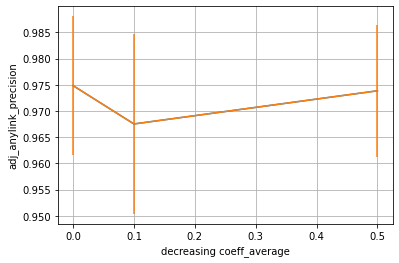

In [10]:
fig, (axs) = plt.subplots(1,1, figsize=(6,  4))#, layout="constrained")
# axs = axs.ravel()
x = [0., 0.1, 0.5]
y = []
y_err = []
for i in range(len(x)):
    results = get_metrics_from_config(config_list[i])
    y.append(results['adj_anylink_precision'][0])
    y_err.append(results['adj_anylink_precision'][1])
    
color1 = 'tab:orange'
axs.plot(x,y)
axs.errorbar(x,y,yerr = y_err)
axs.set_xlabel('decreasing coeff_average')
axs.set_ylabel('adj_anylink_precision')#,color=color1)
axs.tick_params(axis='y')#, labelcolor=color1)
axs.grid(True)

### General plotting func

What to plot: - Plot precision-recall in a single plot (.twinx)
              - Make a plottigng function specific to the "neg" parameter


#### Helper Funcs

In [45]:
def color_picker(method):
    if 'vec' in method:
        return 'green'
    elif 'pca' in method:
        return 'lightblue'#'lightgreen'#'orange' #'blue'
    elif 'avg' in method:
        return 'red' #'red','yellow','orange'
    else:
        return 'grey'

In [46]:
save_folder = os.path.expanduser('~') + '/Documents/Python/Mult_CI_Tests/local_figures/'
which = 'neg'#'ext_er'
def plotting_args(which):
    
    if which == 'neg':
        ##################
        # Plotting globals
        ##################
        d_macro = 5
        d_micro = 5
        T = 200
        coeff = 0.5
        auto = 0.3
        contemp_frac = 1.0
        pc_alpha = 0.01
        tau_max = 0
        corr_type = 'gcm_gmb'
        reg_type = 'ols'
        internal_ER = 0.3 
        external_ER = 0.5    
        ####################
        # Plotting local args
        ####################
        paras = [0., 0.2, 0.4, 0.6, 0.8, 1.]#[0.,0.1,0.2,0.3,0.4,0.5]#[0., 0.1, 0.5]
        plots = ['adj_anylink_precision', 'adj_anylink_recall', #'all_precision', 'all_recall']
                 'edgemarks_anylink_precision', 'edgemarks_anylink_recall', 'unoriented_anylink','computation_time']
        methods = ['vec_pcmci', 'avg_pcmci']#['pca_pcmci_2']
        mech = 'mrf_ts'
                
        return (d_macro, d_micro, T, coeff, auto, contemp_frac, pc_alpha, tau_max, 
            corr_type, reg_type,internal_ER,external_ER,paras,plots,methods,mech)

    elif which == 'ext_er':
        ##################
        # Plotting globals
        ##################
        d_macro = 5
        d_micro = 5
        T = 200
        coeff = 0.5
        auto = 0.3
        contemp_frac = 1.0
        pc_alpha = 0.01
        tau_max = 0
        corr_type = 'gcm_gmb'
        reg_type = 'ols'
        internal_ER = 0.3 
        neg = 1.0
        #### MIGHT HAVE TO COMMENT PCA_WEIGHT OUT DEPENDING ON WHICH PARAMS ####
        pca_weight = 0.
        #########
        ####################
        # Plotting local args
        ####################
        paras = [1., 0.7, 0.5, 0.3, 0.1]#[0.1, 0.3, 0.5, 0.7, 1.]#[0.,0.1,0.2,0.3,0.4,0.5]#[0., 0.1, 0.5]
        plots = ['adj_anylink_precision', 'adj_anylink_recall',# 'all_precision', 'all_recall']
                 'edgemarks_anylink_precision', 'edgemarks_anylink_recall', 'unoriented_anylink','computation_time']
        methods = ['vec_pcmci','pca_pcmci']#['pca_pcmci_2']
        mech = 'mrf_ts'
                
        return (d_macro, d_micro, T, coeff, auto, contemp_frac, pc_alpha, tau_max, 
            corr_type, reg_type,internal_ER,neg,pca_weight,paras,plots,methods,mech)
    
    elif which == 'int_er':
        ##################
        # Plotting globals
        ##################
        d_macro = 5
        d_micro = 5
        T = 200
        coeff = 0.5
        auto = 0.3
        contemp_frac = 1.0
        pc_alpha = 0.01
        tau_max = 0
        corr_type = 'gcm_gmb'
        reg_type = 'ols'
        external_ER = 0.5 
        neg = 1.0
        ####################
        # Plotting local args
        ####################
        paras = [1., 0.7, 0.5, 0.3, 0.1]#[0.,0.1,0.2,0.3,0.4,0.5]#[0., 0.1, 0.5]
        plots = ['adj_anylink_precision', 'adj_anylink_recall',# 'all_precision', 'all_recall',
                 'edgemarks_anylink_precision', 'edgemarks_anylink_recall', 'unoriented_anylink','computation_time']
        methods = ['vec_pcmci', 'vanilla_pcmci']#['pca_pcmci_2']
        mech = 'mrf_ts'
                
        return (d_macro, d_micro, T, coeff, auto, contemp_frac, pc_alpha, tau_max, 
            corr_type, reg_type,external_ER,neg, paras,plots,methods,mech)
    
    elif which == 'pca_weight':
        ##################
        # Plotting globals
        ##################
        d_macro = 5
        d_micro = 5
        T = 200
        coeff = 0.5
        auto = 0.3
        contemp_frac = 1.0
        pc_alpha = 0.01
        tau_max = 0
        corr_type = 'gcm_gmb'
        reg_type = 'ols'
        internal_ER = 0.3 
        external_ER = 1.
        neg = 1.0
        ####################
        # Plotting local args
        ####################
        paras = [2,5,10,20] #[0.4,0.3, 0.2,0.1, 0.]
        plots = ['adj_anylink_precision', 'adj_anylink_recall',# 'all_precision', 'all_recall']
                 'edgemarks_anylink_precision', 'edgemarks_anylink_recall', 'unoriented_anylink','computation_time']
        methods = ['vec_pcmci','pca_pcmci']#['pca_pcmci_2']
        mech = 'mrf_ts_weighted_cov'  
                #'mrf_ts_online_pca_bias' #ONLINE BIAS TO NONSTATIONARITY AND LOW RECALL EVEN FOR VEC-PC FOR HIGH EXT_ER
                
        return (d_macro, d_micro, T, coeff, auto, contemp_frac, pc_alpha, tau_max, 
            corr_type, reg_type,internal_ER,external_ER, neg, paras,plots,methods,mech)
        
        
    
    else:
        raise ValueError("Enter correct plot type")




In [212]:
###############
# Plotting FUNC
###############

def generate_plots(which,
                   paras,
                   plots, 
                   methods, 
                   mech,
                   save = 'no'):
    if len(plots)==2:
        fig, (axs) = plt.subplots(2,1, figsize=(6,  6))
        axs = axs.ravel()
    elif len(plots) == 4:
        fig, (axs) = plt.subplots(2,2, figsize=(12,  6))
        axs = axs.ravel()
    elif len(plots) == 6:
        fig, (axs) = plt.subplots(3,2, figsize=(10,  10))
        axs = axs.ravel()
    elif len(plots) == 8:
        fig, (axs) = plt.subplots(4,2, figsize=(8,  8))
        axs = axs.ravel()
    else:
        raise ValueError("Enter correct subplots dimensions")
        
    
    y_list = np.zeros((len(methods),len(plots),len(paras)))
    yerr_list = np.zeros((len(methods),len(plots),len(paras)))
    x_list = np.zeros(len(paras))
    
    for method in methods:
        for para in paras:
            para_plot = paras.index(para) + methods.index(method)/float(len(methods))*.6
            x_list[paras.index(para)] = para_plot
            
            if which == 'neg':
                d_macro_here = d_macro
                d_micro_here = d_micro
                T_here = T
                coeff_here = coeff
                auto_here = auto
                contemp_frac_here = contemp_frac
                pc_alpha_here = pc_alpha
                tau_max_here = tau_max
                corr_type_here = corr_type
                reg_type_here = reg_type
                internal_ER_here = internal_ER
                external_ER_here = external_ER
                
                para_setup = (mech,
                              d_macro_here, d_micro_here, T_here, coeff_here, auto_here, contemp_frac_here, pc_alpha_here, tau_max_here, 
                              method,
                              corr_type_here, reg_type_here, internal_ER_here, external_ER_here,
                             para)
                name = '%s-'*len(para_setup) % para_setup
                para_setup = name[:-1]
                metrics_dict = get_metrics_from_config(para_setup)
            
            elif which == 'ext_er':
                d_macro_here = d_macro
                d_micro_here = d_micro
                T_here = T
                coeff_here = coeff
                auto_here = auto
                contemp_frac_here = contemp_frac
                pc_alpha_here = pc_alpha
                tau_max_here = tau_max
                corr_type_here = corr_type
                reg_type_here = reg_type
                internal_ER_here = internal_ER
                neg_here = neg
                pca_weight_here = pca_weight
                
                para_setup = (mech,
                              d_macro_here, d_micro_here, T_here, coeff_here, auto_here, contemp_frac_here, pc_alpha_here, tau_max_here, 
                              method,
                              corr_type_here, reg_type_here, internal_ER_here,
                             para, neg_here, pca_weight_here)
                name = '%s-'*len(para_setup) % para_setup
                para_setup = name[:-1]
                metrics_dict = get_metrics_from_config(para_setup)
                
            elif which == 'pca_weight':
                d_macro_here = d_macro
                d_micro_here = d_micro
                T_here = T
                coeff_here = coeff
                auto_here = auto
                contemp_frac_here = contemp_frac
                pc_alpha_here = pc_alpha
                tau_max_here = tau_max
                corr_type_here = corr_type
                reg_type_here = reg_type
                internal_ER_here = internal_ER
                external_ER_here = external_ER
                neg_here = neg
                # pca_weight_here = pca_weight
                
                para_setup = (mech,
                              d_macro_here, d_micro_here, T_here, coeff_here, auto_here, contemp_frac_here, pc_alpha_here, tau_max_here, 
                              method,
                              corr_type_here, reg_type_here, internal_ER_here,
                             external_ER_here, neg_here, para)
                name = '%s-'*len(para_setup) % para_setup
                para_setup = name[:-1]
                metrics_dict = get_metrics_from_config(para_setup)
                
            elif which == 'int_er':
                d_macro_here = d_macro
                d_micro_here = d_micro
                T_here = T
                coeff_here = coeff
                auto_here = auto
                contemp_frac_here = contemp_frac
                pc_alpha_here = pc_alpha
                tau_max_here = tau_max
                corr_type_here = corr_type
                reg_type_here = reg_type
                external_ER_here = external_ER
                neg_here = neg
                
                para_setup = (mech,
                              d_macro_here, d_micro_here, T_here, coeff_here, auto_here, contemp_frac_here, pc_alpha_here, tau_max_here, 
                              method,
                              corr_type_here, reg_type_here,
                             para, external_ER_here, neg_here)
                name = '%s-'*len(para_setup) % para_setup
                para_setup = name[:-1]
                metrics_dict = get_metrics_from_config(para_setup)
                            
            if metrics_dict is None:
                raise ValueError('metrics dict is empty for config:', para_setup)
            else:                
                for j, plot_type in enumerate(plots):
                    # axs[j].errorbar(para_plot, *metrics_dict[plot_type], capsize = .5, 
                    #                 color=color_picker(method),marker = 'o', linestyle='solid')
                    axs[j].set_title(plot_type, fontsize=10,pad = 2)
                    axs[j].grid(True)     
                    if plot_type == 'computation_time':
                        y_list[methods.index(method),j,paras.index(para)] =  metrics_dict[plot_type][0]
                        yerr_list[methods.index(method),j,paras.index(para)] = metrics_dict['computation_time'][1][0]#.reshape(2, 1)
                    else:
                        y_list[methods.index(method),j,paras.index(para)], yerr_list[methods.index(method),j,paras.index(para)] = metrics_dict[plot_type]
            
        for i,ax in enumerate(axs):
            if which == 'neg' or which == 'ext_er' or which == 'int_er' or which == 'pca_weight':  
                ax.errorbar(x_list, y_list[methods.index(method), i], yerr = yerr_list[methods.index(method), i],
                            color=color_picker(method),marker = 'o', linestyle='solid')
                ax.set_xlim(-0.5, len(paras)-0.5)  
                if 'computation_time' in plots:
                    if i == plots.index('computation_time'):
                        ax.set_ylim(-0.2, 2.9)  
                    else:
                        ax.set_ylim(0., 1.1)  
                ax.xaxis.set_ticks([paras.index(p) for p in paras] )
                ax.xaxis.set_ticklabels([str(p) for p in paras] )
                    
        if which == 'neg':
            plt.errorbar([], [], linestyle='solid',
                            capsize=.5, label=method,
                            color=color_picker(method), marker='o')
            plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
            
            plt.figtext(0.5, 0.05, r"fraction of skewness", fontsize=12,
                horizontalalignment='center', va='bottom')
            plt.figtext(.65, .96, r"$T=%d, int_{prob}=%s, cross_{prob}=%s$" %(T, internal_ER, external_ER) 
                                +"\n" + r"$\tau_{\max}=%d$, $d_{micro}=%s$, $d_{macro}=%s$" %(tau_max,d_micro,d_macro),
             fontsize=12, bbox=dict(boxstyle='round', fc='w'), ha='right', va='top')
            
            para_setup_name = (which,mech,method,
                          d_macro_here, d_micro_here, T_here, coeff_here, auto_here, contemp_frac_here, pc_alpha_here, tau_max_here, 
                          corr_type_here, reg_type_here, internal_ER_here, external_ER_here)
            save_suffix = '%s-'*len(para_setup_name) % para_setup_name
            
        elif which == 'ext_er':
            plt.errorbar([], [], linestyle='solid',
                            capsize=.5, label=method,
                            color=color_picker(method), marker='o')
            plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
            
            plt.figtext(0.5, 0.05, r"cross_edge_density", fontsize=12,
                horizontalalignment='center', va='bottom')
            plt.figtext(1., 0.95, r"$T=%d, int_{prob}=%s, 1^{st} \ PC\ wt.=%s$" %(T, internal_ER_here, pca_weight_here) 
                                +"\n" + r"$\tau_{\max}=%d$, $d_{micro}=%s$, $d_{macro}=%s$" %(tau_max,d_micro,d_macro),
             fontsize=12, bbox=dict(boxstyle='round', fc='w') , ha='right', va='top')
            
            para_setup_name = (which,mech,method,
                          d_macro_here, d_micro_here, T_here, coeff_here, auto_here, contemp_frac_here, pc_alpha_here, tau_max_here, 
                          corr_type_here, reg_type_here, internal_ER_here, neg_here, pca_weight_here)
            save_suffix = '%s-'*len(para_setup_name) % para_setup_name
            
            
        elif which == 'pca_weight':
            plt.errorbar([], [], linestyle='solid',
                            capsize=.5, label=method,
                            color=color_picker(method), marker='o')
            plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
            
            plt.figtext(0.5, 0.05, r"weighting_of_noises", fontsize=12,#r"weight_of_1st_PC", fontsize=12,
                horizontalalignment='center', va='bottom')
            plt.figtext(1., 0.95, r"$T=%d, int_{prob}=%s,ext_{prob}=%s$" %(T, internal_ER_here, external_ER_here) 
                                +"\n" + r"$\tau_{\max}=%d$, $d_{micro}=%s$, $d_{macro}=%s$" %(tau_max,d_micro,d_macro),
             fontsize=12, bbox=dict(boxstyle='round', fc='w') , ha='right', va='top')
            para_setup_name = ('cov_weight',mech,method, #(which,mech,method,
                          d_macro_here, d_micro_here, T_here, coeff_here, auto_here, contemp_frac_here, pc_alpha_here, tau_max_here, 
                          corr_type_here, reg_type_here, internal_ER_here, external_ER_here, neg_here)
            save_suffix = '%s-'*len(para_setup_name) % para_setup_name
            
            
        elif which == 'int_er':
            plt.errorbar([], [], linestyle='solid',
                            capsize=.5, label=method,
                            color=color_picker(method), marker='o')
            plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
            
            plt.figtext(0.5, 0.03, r"Decreasing internal_edge_density", fontsize=12,
                horizontalalignment='center', va='bottom')
            plt.figtext(1., 1., r"$T=%d, cross \ edge \ density=%s$" %(T, external_ER_here) 
                                +"\n" + r"$\tau_{\max}=%d$, $d_{micro}=%s$, $d_{macro}=%s$" %(tau_max,d_micro,d_macro),
             fontsize=12, bbox=dict(boxstyle='round', fc='w'), ha='right', va='top')
            
            para_setup_name = (which,mech,method,
                          d_macro_here, d_micro_here, T_here, coeff_here, auto_here, contemp_frac_here, pc_alpha_here, tau_max_here, 
                          corr_type_here, reg_type_here, external_ER_here, neg_here)
            save_suffix = '%s-'*len(para_setup_name) % para_setup_name
            
            print(para_setup_name)
            
        
    if save == 'yes':
        save_type = 'pdf'
        fig.savefig(save_folder + '%s.%s' %(save_suffix, save_type),bbox_inches = 'tight')


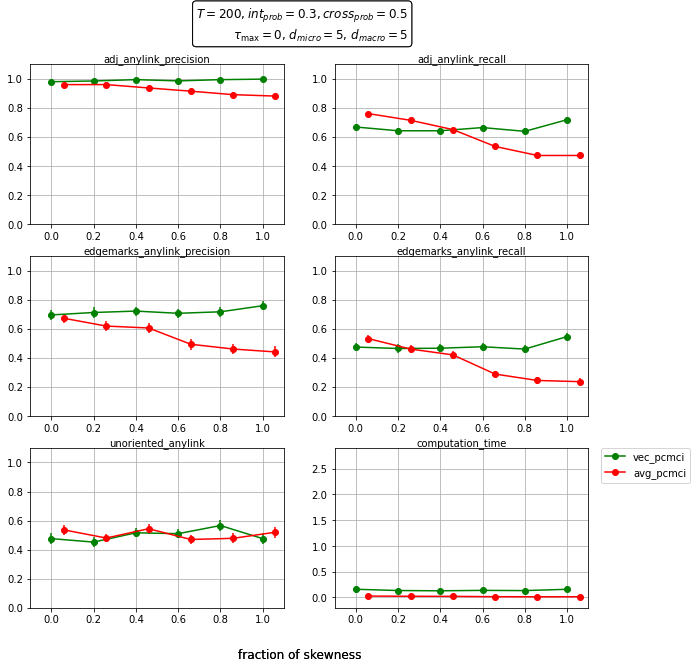

In [213]:
## For 'int_er'
##############
# which  =  'int_er'
# (d_macro, d_micro, T, coeff, auto, contemp_frac, pc_alpha, tau_max, 
#             corr_type, reg_type,external_ER,neg, paras,plots,methods,mech) = plotting_args(which)

## For 'ext_er'
##############
# which  =  'ext_er'
# (d_macro, d_micro, T, coeff, auto, contemp_frac, pc_alpha, tau_max, 
#             corr_type, reg_type,internal_ER,neg,pca_weight,paras,plots,methods,mech) = plotting_args(which)

## For 'pca_weight'
##############
# which  =  'pca_weight'
# (d_macro, d_micro, T, coeff, auto, contemp_frac, pc_alpha, tau_max, 
#             corr_type, reg_type,internal_ER,external_ER, neg, paras,plots,methods,mech) = plotting_args(which)

## For 'neg'
##############
which  =  'neg'
(d_macro, d_micro, T, coeff, auto, contemp_frac, pc_alpha, tau_max, 
            corr_type, reg_type,internal_ER,external_ER,paras,plots,methods,mech) = plotting_args(which)

generate_plots(which,
                   paras,
                   plots, 
                   methods, 
                   mech,
              save= 'no')

## Final plots for paper

In [551]:
save_folder = os.path.expanduser('~') + '/Documents/Python/Mult_CI_Tests/local_figures/'
which = 'neg'#'ext_er'
def plotting_args_all(which):
    
    if which == 'neg':
        ##################
        # Plotting globals
        ##################
        d_macro = 5
        d_micro = 5
        T = 200
        coeff = 0.5
        auto = 0.3
        contemp_frac = 1.0 #0.3
        pc_alpha = 0.01
        tau_max = 0 #1
        corr_type = 'gcm_gmb'
        reg_type = 'ols'
        internal_ER = 0.3 
        external_ER = 0.5    
        ####################
        # Plotting local args
        ####################
        paras = [0., 0.2, 0.4, 0.6, 0.8, 1.]#[0.,0.1,0.2,0.3,0.4,0.5]#[0., 0.1, 0.5]
        plots = ['adj_anylink_precision', 'adj_anylink_recall', 
                 'edgemarks_anylink_precision', 'edgemarks_anylink_recall']
                # ['adj_anylink_precision', 'adj_anylink_recall', 'unoriented_anylink',#'all_precision', 'all_recall']
                #  'edgemarks_anylink_precision', 'edgemarks_anylink_recall','computation_time']
        
        methods = ['vec_pcmci', 'avg_pcmci']#['pca_pcmci_2']
        mech = 'mrf_ts' # 'coarse_dag'
                
        return (d_macro, d_micro, T, coeff, auto, contemp_frac, pc_alpha, tau_max, 
            corr_type, reg_type,internal_ER,external_ER,paras,plots,methods,mech)

    elif which == 'ext_er':
        ##################
        # Plotting globals
        ##################
        d_macro = 5
        d_micro = 5 #3 for time series case
        T = 200
        coeff = 0.5
        auto = 0.3
        contemp_frac = 1.0#0.3
        pc_alpha = 0.01
        tau_max = 0#1
        corr_type = 'gcm_gmb'
        reg_type = 'ols'
        internal_ER = 0.3 
        neg = 1.0
        #### MIGHT HAVE TO COMMENT PCA_WEIGHT OUT DEPENDING ON WHICH PARAMS ####
        pca_weight = 0. #0.4 #None
        #########
        ####################
        # Plotting local args
        ####################
        paras = [0.1, 0.3, 0.5, 0.7, 1.]#[1., 0.7, 0.5, 0.3, 0.1]#[0.1, 0.3, 0.5, 0.7, 1.]#[0.1,0.2,0.3,0.4,0.5]
        plots = ['adj_anylink_precision', 'adj_anylink_recall', 
                 'edgemarks_anylink_precision', 'edgemarks_anylink_recall']
                # ['adj_anylink_precision', 'adj_anylink_recall', 'unoriented_anylink',#'all_precision', 'all_recall']
                #  'edgemarks_anylink_precision', 'edgemarks_anylink_recall','computation_time']
        methods = ['vec_pcmci','pca_pcmci']#['pca_pcmci_2']
        mech = 'mrf_ts'#'coarse_dag' 
                
        return (d_macro, d_micro, T, coeff, auto, contemp_frac, pc_alpha, tau_max, 
            corr_type, reg_type,internal_ER,neg,pca_weight,paras,plots,methods,mech)
    
    elif which == 'int_er':
        ##################
        # Plotting globals
        ##################
        d_macro = 5
        d_micro = 5
        T = 200
        coeff = 0.5
        auto = 0.3
        contemp_frac = 1.0#0.3
        pc_alpha = 0.01
        tau_max = 0#1
        corr_type = 'gcm_gmb'
        reg_type = 'ols'
        external_ER = 0.5 
        neg = 1.0
        ####################
        # Plotting local args
        ####################
        paras = [0.1, 0.3, 0.5, 0.7,1.] #[1., 0.7, 0.5, 0.3, 0.1]
        plots =['adj_anylink_precision', 'adj_anylink_recall', 'unoriented_anylink',#'all_precision', 'all_recall']
                 'edgemarks_anylink_precision', 'edgemarks_anylink_recall','computation_time']
        methods = ['vec_pcmci', 'vanilla_pcmci']#['pca_pcmci_2']
        mech = 'mrf_ts' #'coarse_dag' #
                
        return (d_macro, d_micro, T, coeff, auto, contemp_frac, pc_alpha, tau_max, 
            corr_type, reg_type,external_ER,neg, paras,plots,methods,mech)
    
    elif which == 'pca_weight':
        ##################
        # Plotting globals
        ##################
        d_macro = 5
        d_micro = 5
        T = 200
        coeff = 0.5
        auto = 0.3
        contemp_frac = 1.0
        pc_alpha = 0.01
        tau_max = 0
        corr_type = 'gcm_gmb'
        reg_type = 'ols'
        internal_ER = 0.3 
        external_ER = 1.
        neg = 1.0
        ####################
        # Plotting local args
        ####################
        paras = [2,5,10,20] #[0.4,0.3, 0.2,0.1, 0.]
        plots = ['adj_anylink_precision', 'adj_anylink_recall',# 'all_precision', 'all_recall']
                 'edgemarks_anylink_precision', 'edgemarks_anylink_recall', 'unoriented_anylink','computation_time']
        methods = ['vec_pcmci','pca_pcmci']#['pca_pcmci_2']
        mech = 'mrf_ts_weighted_cov'  
                #'mrf_ts_online_pca_bias' #ONLINE BIAS TO NONSTATIONARITY AND LOW RECALL EVEN FOR VEC-PC FOR HIGH EXT_ER
                
        return (d_macro, d_micro, T, coeff, auto, contemp_frac, pc_alpha, tau_max, 
            corr_type, reg_type,internal_ER,external_ER, neg, paras,plots,methods,mech)
        
        
    
    else:
        raise ValueError("Enter correct plot type")


In [552]:
def color_picker(method):
    if 'vec' in method:
        return 'green'
    elif 'pca' in method:
        return 'darkviolet'#'sandybrown'#'orange' #'lightblue''lightgreen'#'orange' #'blue'
    elif 'avg' in method:
        return 'red' #'red','yellow','orange'
    else:
        return 'grey'

###############
# Plotting FUNC
###############

def generate_plots_final(which,
                   paras,
                   plots, 
                   methods, 
                   mech,
                   save = 'no'):
    if len(plots)==2:
        fig, (axs) = plt.subplots(2,1, figsize=(6,  6))
        axs = axs.ravel()
    elif len(plots) == 4:
        fig, (axs) = plt.subplots(2,2, figsize=(8,  6))
        axs = axs.ravel()
    elif len(plots) == 6:
        fig, (axs) = plt.subplots(2,3, figsize=(12,  6))
        axs = axs.ravel()
    elif len(plots) == 8:
        fig, (axs) = plt.subplots(4,2, figsize=(8,  8))
        axs = axs.ravel()
    else:
        raise ValueError("Enter correct subplots dimensions")
        
    
    y_list = np.zeros((len(methods),len(plots),len(paras)))
    yerr_list = np.zeros((len(methods),len(plots),len(paras)))
    x_list = np.zeros(len(paras))
    
    for method in methods:
        for para in paras:
            para_plot = paras.index(para) + methods.index(method)/float(len(methods))*.6
            x_list[paras.index(para)] = para_plot
            
            if which == 'neg':
                d_macro_here = d_macro
                d_micro_here = d_micro
                T_here = T
                coeff_here = coeff
                auto_here = auto
                contemp_frac_here = contemp_frac
                pc_alpha_here = pc_alpha
                tau_max_here = tau_max
                corr_type_here = corr_type
                reg_type_here = reg_type
                internal_ER_here = internal_ER
                external_ER_here = external_ER
                
                para_setup = (mech,
                              d_macro_here, d_micro_here, T_here, coeff_here, auto_here, contemp_frac_here, pc_alpha_here, tau_max_here, 
                              method,
                              corr_type_here, reg_type_here, internal_ER_here, external_ER_here,
                             para)
                name = '%s-'*len(para_setup) % para_setup
                para_setup = name[:-1]
                metrics_dict = get_metrics_from_config(para_setup)
            
            elif which == 'ext_er':
                d_macro_here = d_macro
                d_micro_here = d_micro
                T_here = T
                coeff_here = coeff
                auto_here = auto
                contemp_frac_here = contemp_frac
                pc_alpha_here = pc_alpha
                tau_max_here = tau_max
                corr_type_here = corr_type
                reg_type_here = reg_type
                internal_ER_here = internal_ER
                neg_here = neg
                pca_weight_here = pca_weight ## Comment this for time-series case and remove from para_setup below as well
                
                para_setup = (mech,
                              d_macro_here, d_micro_here, T_here, coeff_here, auto_here, contemp_frac_here, pc_alpha_here, tau_max_here, 
                              method,
                              corr_type_here, reg_type_here, internal_ER_here,
                             para, neg_here, pca_weight_here)
                name = '%s-'*len(para_setup) % para_setup
                para_setup = name[:-1]
                metrics_dict = get_metrics_from_config(para_setup)
                
            elif which == 'pca_weight':
                d_macro_here = d_macro
                d_micro_here = d_micro
                T_here = T
                coeff_here = coeff
                auto_here = auto
                contemp_frac_here = contemp_frac
                pc_alpha_here = pc_alpha
                tau_max_here = tau_max
                corr_type_here = corr_type
                reg_type_here = reg_type
                internal_ER_here = internal_ER
                external_ER_here = external_ER
                neg_here = neg
                # pca_weight_here = pca_weight
                
                para_setup = (mech,
                              d_macro_here, d_micro_here, T_here, coeff_here, auto_here, contemp_frac_here, pc_alpha_here, tau_max_here, 
                              method,
                              corr_type_here, reg_type_here, internal_ER_here,
                             external_ER_here, neg_here, para)
                name = '%s-'*len(para_setup) % para_setup
                para_setup = name[:-1]
                metrics_dict = get_metrics_from_config(para_setup)
                
            elif which == 'int_er':
                d_macro_here = d_macro
                d_micro_here = d_micro
                T_here = T
                coeff_here = coeff
                auto_here = auto
                contemp_frac_here = contemp_frac
                pc_alpha_here = pc_alpha
                tau_max_here = tau_max
                corr_type_here = corr_type
                reg_type_here = reg_type
                external_ER_here = external_ER
                neg_here = neg
                
                para_setup = (mech,
                              d_macro_here, d_micro_here, T_here, coeff_here, auto_here, contemp_frac_here, pc_alpha_here, tau_max_here, 
                              method,
                              corr_type_here, reg_type_here,
                             para, external_ER_here, neg_here)
                name = '%s-'*len(para_setup) % para_setup
                para_setup = name[:-1]
                metrics_dict = get_metrics_from_config(para_setup)
                            
            if metrics_dict is None:
                raise ValueError('metrics dict is empty for config:', para_setup)
            else:                
                for j, plot_type in enumerate(plots):
                    # axs[j].errorbar(para_plot, *metrics_dict[plot_type], capsize = .5, 
                    #                 color=color_picker(method),marker = 'o', linestyle='solid')
                    # axs[j].set_title(plot_type, fontsize=10,pad = 2)
                    axs[j].grid(True)     
                    if plot_type == 'computation_time':
                        y_list[methods.index(method),j,paras.index(para)] =  metrics_dict[plot_type][0]
                        yerr_list[methods.index(method),j,paras.index(para)] = metrics_dict['computation_time'][1][0]#.reshape(2, 1)
                    else:
                        y_list[methods.index(method),j,paras.index(para)], yerr_list[methods.index(method),j,paras.index(para)] = metrics_dict[plot_type]
            
        for i,ax in enumerate(axs):
            if which == 'neg' or which == 'ext_er' or which == 'int_er' or which == 'pca_weight':  
                ax.errorbar(x_list, y_list[methods.index(method), i], yerr = yerr_list[methods.index(method), i],
                            color=color_picker(method),marker = 'o', linestyle='solid')
                ax.set_xlim(-0.5, len(paras)-0.5)  
                if 'computation_time' in plots:
                    if i == plots.index('computation_time'):
                        ax.set_ylim(-0.2, 7.0) #2.9 
                    else:
                        ax.set_ylim(0., 1.1)  
                else:
                        ax.set_ylim(0., 1.1)
                ax.xaxis.set_ticks([paras.index(p) for p in paras] )
                ax.xaxis.set_ticklabels([str(p) for p in paras] )
          
        if tau_max_here == 0:
            method_name = method.replace('pcmci', 'PC')
        else:
            method_name = method
        if 'vanilla' in method_name:
            method_name = method_name.replace('vanilla', 'component')
                    
        if which == 'neg':
            plt.errorbar([], [], linestyle='solid',
                            capsize=.5, label=method_name,
                            color=color_picker(method), marker='o')
            plt.legend(bbox_to_anchor=(0.53, 0.96), loc='upper left', borderaxespad=0.)
            
            plt.figtext(0.515, 0.04, r"Symmetry of coefficient interval", fontsize=12,
                horizontalalignment='center', va='bottom')
            plt.figtext(.7, 1.05, r"$T=%d, int_{dens.}=%s, ext_{dens.}=%s$" %(T, internal_ER, external_ER) 
                                +"\n" + r"$\tau_{\max}=%d$, $d_{micro}=%s$, $d_{macro}=%s$" %(tau_max,d_micro,d_macro),
             fontsize=12, bbox=dict(boxstyle='round', fc='w'), ha='right', va='top')
            
            para_setup_name = ('final', which,mech,method,
                          d_macro_here, d_micro_here, T_here, coeff_here, auto_here, contemp_frac_here, pc_alpha_here, tau_max_here, 
                          corr_type_here, reg_type_here, internal_ER_here, external_ER_here)
            save_suffix = '%s-'*len(para_setup_name) % para_setup_name
            
        elif which == 'ext_er':
            plt.errorbar([], [], linestyle='solid',
                            capsize=.5, label=method_name,
                            color=color_picker(method), marker='o')
            plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
            
            plt.figtext(0.5, 0.05, r"cross_edge_density", fontsize=12,
                horizontalalignment='center', va='bottom')
            plt.figtext(.65, 1.04, r"$T=%d, int_{prob}=%s, 1^{st} \ PC\ wt.=%s$" %(T, internal_ER_here, 'None')#pca_weight_here) 
                                +"\n" + r"$\tau_{\max}=%d$, $d_{micro}=%s$, $d_{macro}=%s$" %(tau_max,d_micro,d_macro),
             fontsize=12, bbox=dict(boxstyle='round', fc='w') , ha='right', va='top')
            
            para_setup_name = ('final',which,mech,method,
                          d_macro_here, d_micro_here, T_here, coeff_here, auto_here, contemp_frac_here, pc_alpha_here, tau_max_here, 
                          corr_type_here, reg_type_here, internal_ER_here, neg_here)#, pca_weight_here)
            save_suffix = '%s-'*len(para_setup_name) % para_setup_name
            
            
        elif which == 'pca_weight':
            plt.errorbar([], [], linestyle='solid',
                            capsize=.5, label=method_name,
                            color=color_picker(method), marker='o')
            plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
            
            plt.figtext(0.5, 0.05, r"weighting_of_noises", fontsize=12,#r"weight_of_1st_PC", fontsize=12,
                horizontalalignment='center', va='bottom')
            plt.figtext(.65, 1.04, r"$T=%d, int_{prob}=%s,ext_{prob}=%s$" %(T, internal_ER_here, external_ER_here) 
                                +"\n" + r"$\tau_{\max}=%d$, $d_{micro}=%s$, $d_{macro}=%s$" %(tau_max,d_micro,d_macro),
             fontsize=12, bbox=dict(boxstyle='round', fc='w') , ha='right', va='top')
            para_setup_name = ('cov_weight',mech,method, #(which,mech,method,
                          d_macro_here, d_micro_here, T_here, coeff_here, auto_here, contemp_frac_here, pc_alpha_here, tau_max_here, 
                          corr_type_here, reg_type_here, internal_ER_here, external_ER_here, neg_here)
            save_suffix = '%s-'*len(para_setup_name) % para_setup_name
            
            
        elif which == 'int_er':
            plt.errorbar([], [], linestyle='solid',
                            capsize=.5, label=method_name,
                            color=color_picker(method), marker='o')
            plt.legend(bbox_to_anchor=(0.1, 0.93), loc='upper left', borderaxespad=0.)
            
            plt.figtext(0.51, 0.03, r"Increasing internal edge density", fontsize=12,
                horizontalalignment='center', va='bottom')
            plt.figtext(.63, 1.05, r"$T=%d, \ ext_{dens.}=%s$" %(T, external_ER_here) 
                                +"\n" + r"$\tau_{\max}=%d$, $d_{micro}=%s$, $d_{macro}=%s$" %(tau_max,d_micro,d_macro),
             fontsize=12, bbox=dict(boxstyle='round', fc='w'), ha='right', va='top')
            
            para_setup_name = ('final',which,mech,method,
                          d_macro_here, d_micro_here, T_here, coeff_here, auto_here, contemp_frac_here, pc_alpha_here, tau_max_here, 
                          corr_type_here, reg_type_here, external_ER_here, neg_here)
            save_suffix = '%s-'*len(para_setup_name) % para_setup_name
            
        print(para_setup_name)
            
        
    if save == 'yes':
        save_type = 'pdf'
        fig.savefig(save_folder + '%s.%s' %(save_suffix, save_type),bbox_inches = 'tight')

('final', 'ext_er', 'mrf_ts', 'vec_pcmci', 5, 5, 200, 0.5, 0.3, 1.0, 0.01, 0, 'gcm_gmb', 'ols', 0.3, 1.0)
('final', 'ext_er', 'mrf_ts', 'pca_pcmci', 5, 5, 200, 0.5, 0.3, 1.0, 0.01, 0, 'gcm_gmb', 'ols', 0.3, 1.0)


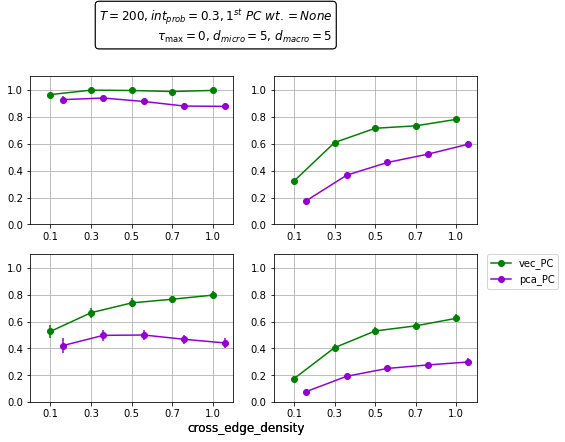

In [553]:
## For 'int_er'
##############
# which  =  'int_er'
# (d_macro, d_micro, T, coeff, auto, contemp_frac, pc_alpha, tau_max, 
#             corr_type, reg_type,external_ER,neg, paras,plots,methods,mech) = plotting_args_all(which)

## For 'ext_er'
##############
which  =  'ext_er'
(d_macro, d_micro, T, coeff, auto, contemp_frac, pc_alpha, tau_max, 
            corr_type, reg_type,internal_ER,neg,pca_weight,paras,plots,methods,mech) = plotting_args_all(which)

## For 'pca_weight'
##############
# which  =  'pca_weight'
# (d_macro, d_micro, T, coeff, auto, contemp_frac, pc_alpha, tau_max, 
#             corr_type, reg_type,internal_ER,external_ER, neg, paras,plots,methods,mech) = plotting_args_all(which)

## For 'neg'
##############
# which  =  'neg'
# (d_macro, d_micro, T, coeff, auto, contemp_frac, pc_alpha, tau_max, 
#             corr_type, reg_type,internal_ER,external_ER,paras,plots,methods,mech) = plotting_args_all(which)

generate_plots_final(which,
                   paras,
                   plots, 
                   methods, 
                   mech,
              save= 'no')

### Ext_ER Plots

In [322]:
d_macro = 5
d_micro = 5
T = 200
coeff = 0.5
auto = 0.3
contemp_frac = 1.0
pc_alpha = 0.01
tau_max = 0
corr_type = 'gcm_gmb'
reg_type = 'ols'
internal_ER = 0.3 
neg = 1.0
#### MIGHT HAVE TO COMMENT PCA_WEIGHT OUT DEPENDING ON WHICH PARAMS ####
pca_weights = [0., 0.4]
#########
####################
# Plotting local args
####################
paras = [0.1, 0.3, 0.5, 0.7, 1.] #[0.,0.1,0.2,0.3,0.4,0.5]#[0., 0.1, 0.5]
plots = ['adj_anylink_precision', 'adj_anylink_recall', 
         'edgemarks_anylink_precision', 'edgemarks_anylink_recall']
        # ['adj_anylink_precision', 'adj_anylink_recall', 'unoriented_anylink',#'all_precision', 'all_recall']
        #  'edgemarks_anylink_precision', 'edgemarks_anylink_recall','computation_time']
methods = ['vec_pcmci','pca_pcmci']#['pca_pcmci_2']
mech = 'mrf_ts'

In [323]:
def color_picker_ext_er(method, pca_weight):
    if 'vec' in method:
        if pca_weight == 0.:
            return 'yellowgreen'
        elif pca_weight == 0.4:
            return 'darkgreen'
    elif 'pca' in method:
        if pca_weight == 0.:
            return 'violet'
        elif pca_weight == 0.4:
            return 'darkorchid'
    # elif 'avg' in method:
    #     return 'red' #'red','yellow','orange'
    # else:
    #     return 'grey'


In [344]:
def gen_ext_ER_plots(which,
                   paras,
                   plots, 
                   methods, 
                   mech,
                   save = 'no'):
    if len(plots)==2:
        fig, (axs) = plt.subplots(2,1, figsize=(6,  6))
        axs = axs.ravel()
    elif len(plots) == 4:
        fig, (axs) = plt.subplots(2,2, figsize=(8,  6))
        axs = axs.ravel()
    elif len(plots) == 6:
        fig, (axs) = plt.subplots(2,3, figsize=(12,  6))
        axs = axs.ravel()
    elif len(plots) == 8:
        fig, (axs) = plt.subplots(4,2, figsize=(8,  8))
        axs = axs.ravel()
    else:
        raise ValueError("Enter correct subplots dimensions")
        
    
    y_list = np.zeros((len(methods),len(plots),len(paras)))
    yerr_list = np.zeros((len(methods),len(plots),len(paras)))
    x_list = np.zeros(len(paras))
    
    for method in methods:
        for pca_weight in pca_weights:
            for para in paras:
                
                para_plot = paras.index(para) + methods.index(method)/float(len(methods))*.6
                x_list[paras.index(para)] = para_plot


                if which == 'ext_er':
                    d_macro_here = d_macro
                    d_micro_here = d_micro
                    T_here = T
                    coeff_here = coeff
                    auto_here = auto
                    contemp_frac_here = contemp_frac
                    pc_alpha_here = pc_alpha
                    tau_max_here = tau_max
                    corr_type_here = corr_type
                    reg_type_here = reg_type
                    internal_ER_here = internal_ER
                    neg_here = neg
                    pca_weight_here = pca_weight

                    para_setup = (mech,
                                  d_macro_here, d_micro_here, T_here, coeff_here, auto_here, contemp_frac_here, pc_alpha_here, tau_max_here, 
                                  method,
                                  corr_type_here, reg_type_here, internal_ER_here,
                                 para, neg_here, pca_weight_here)
                    name = '%s-'*len(para_setup) % para_setup
                    para_setup = name[:-1]
                    metrics_dict = get_metrics_from_config(para_setup)                

                if metrics_dict is None:
                    raise ValueError('metrics dict is empty for config:', para_setup)
                else:                
                    for j, plot_type in enumerate(plots):
                        # axs[j].set_title(plot_type, fontsize=10,pad = 2)
                        axs[j].grid(True)     
                        if plot_type == 'computation_time':
                            y_list[methods.index(method),j,paras.index(para)] =  metrics_dict[plot_type][0]
                            yerr_list[methods.index(method),j,paras.index(para)] = metrics_dict['computation_time'][1][0]#.reshape(2, 1)
                        else:
                            y_list[methods.index(method),j,paras.index(para)], yerr_list[methods.index(method),j,paras.index(para)] = metrics_dict[plot_type]

            for i,ax in enumerate(axs):
                if which == 'ext_er':  
                    if pca_weight == 0.:
                        line_style = 'dashed'
                    else:
                        line_style = 'solid'
                    ax.errorbar(x_list, y_list[methods.index(method), i], yerr = yerr_list[methods.index(method), i],
                                color=color_picker_ext_er(method, pca_weight),marker = 'o', linestyle=line_style)
                    ax.set_xlim(-0.5, len(paras)-0.5)  
                    if 'computation_time' in plots:
                        if i == plots.index('computation_time'):
                            ax.set_ylim(-0.2, 2.9)  
                        else:
                            ax.set_ylim(0., 1.1)  
                    else:
                            ax.set_ylim(0., 1.1)
                    ax.xaxis.set_ticks([paras.index(p) for p in paras] )
                    ax.xaxis.set_ticklabels([str(p) for p in paras] )

            method_name = method.replace('pcmci', 'PC')
            method_name = method_name.replace('PC', 'PC_'+str(pca_weight))
            # if 'pca' in method_name:
            #     method_name = method_name.replace('pca', 'pca_'+str(pca_weight))
            # else:
            #     method_name = method_name.replace('vec', 'vec_'+str(pca_weight))


            if which == 'ext_er':
                plt.errorbar([], [], linestyle='solid',
                                capsize=.5, label=method_name,
                                color=color_picker_ext_er(method, pca_weight), marker='o')
                plt.legend(bbox_to_anchor=(-1.08, 1.8), loc='upper left', borderaxespad=0.)

                plt.figtext(0.5, 0.03, r"cross edge density ($ext_{dens.}$)", fontsize=12,
                    horizontalalignment='center', va='bottom')
                plt.figtext(.65, 1.04, r"$T=%d, int_{dens.}=%s$" %(T, internal_ER_here) 
                                    +"\n" + r"$\tau_{\max}=%d$, $d_{micro}=%s$, $d_{macro}=%s$" %(tau_max,d_micro,d_macro),
                 fontsize=12, bbox=dict(boxstyle='round', fc='w') , ha='right', va='top')

                para_setup_name = ('final',which,mech,method,
                              d_macro_here, d_micro_here, T_here, coeff_here, auto_here, contemp_frac_here, pc_alpha_here, tau_max_here, 
                              corr_type_here, reg_type_here, internal_ER_here, neg_here, pca_weight_here)
                save_suffix = '%s-'*len(para_setup_name) % para_setup_name



        if save == 'yes':
            save_type = 'pdf'
            fig.savefig(save_folder + '%s.%s' %(save_suffix, save_type),bbox_inches = 'tight')

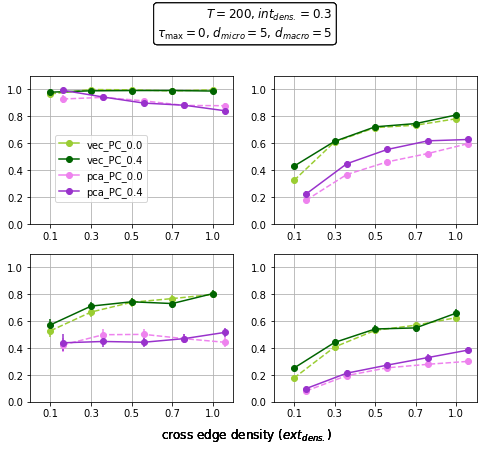

In [346]:
## For 'ext_er'
##############
which  =  'ext_er'
# (d_macro, d_micro, T, coeff, auto, contemp_frac, pc_alpha, tau_max, 
#             corr_type, reg_type,internal_ER,neg,pca_weight,paras,plots,methods,mech) = plotting_args_all(which)


gen_ext_ER_plots(which,
                   paras,
                   plots, 
                   methods, 
                   mech,
              save= 'yes')

# Archive

In [34]:
# save = 'no'
# which  =  'pca_weight'

## For 'int_er'
##############
# (d_macro, d_micro, T, coeff, auto, contemp_frac, pc_alpha, tau_max, 
#             corr_type, reg_type,external_ER,neg, paras,plots,methods,mech) = plotting_args(which)

## For 'ext_er'
##############
# (d_macro, d_micro, T, coeff, auto, contemp_frac, pc_alpha, tau_max, 
#             corr_type, reg_type,internal_ER,neg,pca_weight,paras,plots,methods,mech) = plotting_args(which)

## For 'pca_weight'
##############
# (d_macro, d_micro, T, coeff, auto, contemp_frac, pc_alpha, tau_max, 
#             corr_type, reg_type,internal_ER,external_ER, neg, paras,plots,methods,mech) = plotting_args(which)

## For 'neg'
##############
# (d_macro, d_micro, T, coeff, auto, contemp_frac, pc_alpha, tau_max, 
#             corr_type, reg_type,internal_ER,external_ER,paras,plots,methods,mech) = plotting_args(which)

# generate_plots(which,
#                    paras,
#                    plots, 
#                    methods, 
#                    mech)

In [159]:
def plot_neg(config_list):
    
    fig, (axs) = plt.subplots(5,1, figsize=(6,  4))
    axs = axs.ravel()
    
    y_avg = []
    y_avg_err = []
    
    for config in config_list:
        
        results = get_metrics_from_config(config)
        paras = config.split('-')
        paras = [w.replace("'","") for w in paras]

        # Extract parameters from paras
        method = str(paras[9])
        print('METHOD is', method)
        neg = float(paras[14])
        
        # y_avg = {}
        y_avg = {x: list() for x in results.keys()}
        y_avg_err = {x: list() for x in results.keys()}
        
        if method == 'pca_pcmci_2':
            for plot_type in results.keys():
                y_avg[plot_type].append(results[plot_type][0])
                y_avg_err[plot_type].append(results[plot_type][1])
                x.append(neg)
                
        print(y_avg)
        print(y_avg_err)
        
        ## TODO: The order of the loops is still wrong: the plot_type loop should be outside and the config_list inside
        ## Or is there anty other way of doing this?
            
        
        # results = get_metrics_from_config(config)
        
        # j=0
        # y_avg = []
        # y_avg_err = []
        # for plot_type in results.keys():
        #     if method == 'vec_pcmci':
        #         y_vec.append()
        #         y_vec_err.append()
        #         x.append(neg)
        #     elif method == 'pca_pcmci_2':
        #         print('---')
        #         y_avg.append(results[plot_type][0])
        #         y_avg_err.append(results[plot_type][1])
        #         x.append(neg)

            # axs[j].plot(x,y_vec, yerr = y_vec_err)
            # axs[j].plot(x, y_avg, yerr = y_avg_err)
            # axs[j].title.set_text(plot_type)
            # j+=1

        

METHOD is pca_pcmci_2
{'adj_anylink_precision': [1.0], 'adj_anylink_recall': [0.75], 'all_precision': [0.0], 'all_recall': [0.0], 'computation_time': [0.02817845344543457]}
{'adj_anylink_precision': [0.0], 'adj_anylink_recall': [0.16672863431336563], 'all_precision': [0.0], 'all_recall': [0.0], 'computation_time': [array([0.01448717, 0.04186974])]}
METHOD is pca_pcmci_2
{'adj_anylink_precision': [1.0], 'adj_anylink_recall': [1.0], 'all_precision': [0.0], 'all_recall': [0.0], 'computation_time': [0.033214688301086426]}
{'adj_anylink_precision': [0.0], 'adj_anylink_recall': [0.0], 'all_precision': [0.0], 'all_recall': [0.0], 'computation_time': [array([0.0304386 , 0.03599077])]}
METHOD is pca_pcmci_2
{'adj_anylink_precision': [1.0], 'adj_anylink_recall': [0.5], 'all_precision': [0.0], 'all_recall': [0.0], 'computation_time': [0.019432425498962402]}
{'adj_anylink_precision': [0.0], 'adj_anylink_recall': [0.0], 'all_precision': [0.0], 'all_recall': [0.0], 'computation_time': [array([0.0139

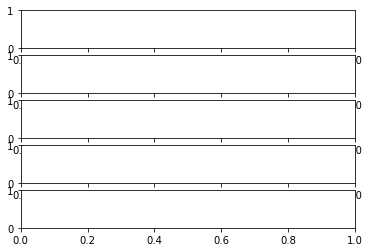

In [160]:
plot_neg(config_list)

In [141]:
y

[1.0, 1.0, 1.0]

In [106]:
y_err

[0.0, 0.0, 0.0]

In [142]:
config_list

['mrf_ts-3-5-200-0.5-0.3-1.0-0.01-0-pca_pcmci_2-gcm_gmb-ols-0.3-0.5-0.0',
 'mrf_ts-3-5-200-0.5-0.3-1.0-0.01-0-pca_pcmci_2-gcm_gmb-ols-0.3-0.5-0.1',
 'mrf_ts-3-5-200-0.5-0.3-1.0-0.01-0-pca_pcmci_2-gcm_gmb-ols-0.3-0.5-0.5']

In [146]:
dicta = {}

In [147]:
dicta['aa'] = 1

In [148]:
dicta

{'aa': 1}

In [149]:
dicta['aa']+=2

In [150]:
dicta

{'aa': 3}

In [70]:
for conf in list(all_configs.keys()):

    all_configs[conf]['graphs'] = np.zeros((samples, ) + all_configs[conf]['results'][0]['graph'].shape, dtype='<U3')
    all_configs[conf]['true_graphs'] = np.zeros((samples, ) + all_configs[conf]['results'][0]['true_graph'].shape, dtype='<U3')
    all_configs[conf]['computation_time'] = [] 


    for i in list(all_configs[conf]['results'].keys()):
        all_configs[conf]['graphs'][i] = all_configs[conf]['results'][i]['graph']
        all_configs[conf]['true_graphs'][i] = all_configs[conf]['results'][i]['true_graph']
        all_configs[conf]['computation_time'].append(all_configs[conf]['results'][i]['computation_time'])


    del all_configs[conf]['results']

    if os.path.expanduser('~') == '/Users/urmininad':
        file_name = os.path.expanduser('~') + '/Documents/Python/Mult_CI_Tests/Interimresults_vecCI/%s' %(conf)
        file_name_met = os.path.expanduser('~') + '/Documents/Python/Mult_CI_Tests/metrics_vecCI/%s' %(conf)
    else:
        print("wrong path for running locally")

    print("dump ", file_name.replace("'", "").replace('"', '') + '.dat')
    file = open(file_name.replace("'", "").replace('"', '') + '.dat', 'wb')
    pickle.dump(all_configs[conf], file, protocol=-1)        
    file.close()

    # Directly compute metrics and save in much smaller dict
    para_setup_str = tuple(conf.split("-"))
    metrics = met.get_counts(para_setup_str)
    
    if metrics is not None:
        for metric in metrics:
            if metric != 'computation_time':
                print(f"{metric:30s} {metrics[metric][0]: 1.2f} +/-{metrics[metric][1]: 1.2f} ")
            else:
                print(f"{metric:30s} {metrics[metric][0]: 1.2f} +/-[{metrics[metric][1][0]: 1.2f}, {metrics[metric][1][1]: 1.2f}]")

        print("Metrics dump ", file_name_met.replace("'", "").replace('"', '') + '_metrics.dat')
        file = open(file_name_met.replace("'", "").replace('"', '') + '_metrics.dat', 'wb')
        pickle.dump(metrics, file, protocol=-1)        
        file.close()
        
    else:
        print("Metrics is None, CHECK!!!!!")
        

dump  /Users/urmininad/Documents/Python/Mult_CI_Tests/Interimresults_vecCI/mrf_ts-3-5-200-0.5-0.3-1.0-0.01-0-pca_pcmci_2-gcm_gmb-ols-0.3-0.5-0.0.dat
load   /Users/urmininad/Documents/Python/Mult_CI_Tests/Interimresults_vecCI/mrf_ts-3-5-200-0.5-0.3-1.0-0.01-0-pca_pcmci_2-gcm_gmb-ols-0.3-0.5-0.0.dat
NOT NONE YAY!
adj_anylink_precision           1.00 +/- 0.00 
adj_anylink_recall              1.00 +/- 0.00 
all_precision                   0.00 +/- 0.00 
all_recall                      0.00 +/- 0.00 
computation_time                0.04 +/-[ 0.03,  0.04]
Metrics dump  /Users/urmininad/Documents/Python/Mult_CI_Tests/metrics_vecCI/mrf_ts-3-5-200-0.5-0.3-1.0-0.01-0-pca_pcmci_2-gcm_gmb-ols-0.3-0.5-0.0_metrics.dat
dump  /Users/urmininad/Documents/Python/Mult_CI_Tests/Interimresults_vecCI/mrf_ts-3-5-200-0.5-0.3-1.0-0.01-0-pca_pcmci_2-gcm_gmb-ols-0.3-0.5-0.1.dat
load   /Users/urmininad/Documents/Python/Mult_CI_Tests/Interimresults_vecCI/mrf_ts-3-5-200-0.5-0.3-1.0-0.01-0-pca_pcmci_2-gcm_gmb-ols-0.3

/Users/urmininad/Documents/Python/Mult_CI_Tests/metrics_vec_CD.py:93: RuntimeWarning: invalid value encountered in long_scalars
  metric_boot[b] = numerator[rand].sum()/denominator[rand].sum()
